In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from scipy.stats import norm
import time
import math
import pandas as pd
plt.style.use('ggplot')
%matplotlib inline
from scipy.stats import entropy

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('./data/mnist', one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./data/mnist/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./data/mnist/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ./data/mnist/t10k-images-idx3-ubyte.gz
Extracting ./data/mnist/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
X_train = mnist.train.images
y_train = mnist.train.labels

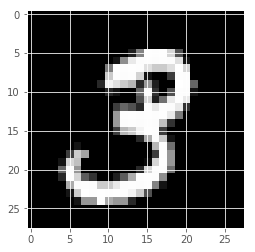

In [4]:
plt.imshow(X_train[1,:].reshape(28,28),cmap='gray')
plt.show()

In [17]:
def neural_network_test(x, W_0, b_0, W_1, b_1,W_2, b_2,W_3, b_3):
    h = tf.nn.relu(tf.matmul(x, W_0) + b_0)
    h = tf.nn.relu(tf.matmul(h, W_1) + b_1)
    h = (tf.matmul(h, W_2) + b_2)
    h = (tf.matmul(h, W_3) + b_3)
    y = tf.nn.softmax(h)
    return y

M =1
D = 28*28
D2 = 10
n_intergal_sample = 10
sigma0=.3
h1 = 600
h2 = 300
h3=200

tf.reset_default_graph()
Y = tf.placeholder(tf.float32, [None,D2], name='Y')
X = tf.placeholder(tf.float32, [None,D], name='X')


mu_w0 = tf.get_variable("w0_mu",[D,h1])
mu_b0 = tf.get_variable("b0_mu",[1,h1])
mu_w1 = tf.get_variable("w1_mu",[h1,h2])
mu_b1 = tf.get_variable("b1_mu",[1,h2])
mu_w2 = tf.get_variable("w2_mu",[h2,h3])
mu_b2 = tf.get_variable("b2_mu",[1,h3])
mu_w3 = tf.get_variable("w3_mu",[h3,D2])
mu_b3 = tf.get_variable("b3_mu",[1,D2])

r_w0 = tf.get_variable("w0_sigma",[D,h1])
r_b0 = tf.get_variable("b0_sigma",[1,h1])
r_w1 = tf.get_variable("w1_sigma",[h1,h2])
r_b1 = tf.get_variable("b1_sigma",[1,h2])
r_w2 = tf.get_variable("w2_sigma",[h2,h3])
r_b2 = tf.get_variable("b2_sigma",[1,h3])
r_w3 = tf.get_variable("w3_sigma",[h3,D2])
r_b3 = tf.get_variable("b3_sigma",[1,D2])



sigma_w0 = r_w0**2
sigma_b0 = r_b0**2
sigma_w1 = r_w1**2
sigma_b1 = r_b1**2
sigma_w2 = r_w2**2
sigma_b2 = r_b2**2
sigma_w3 = r_w3**2
sigma_b3 = r_b3**2


y_model = neural_network_test(X,mu_w0,mu_b0,mu_w1,mu_b1,mu_w2,mu_b2,mu_w3,mu_b3)
likelihood = tf.tensordot(y_model[0],Y[0],1)
cross_ent = tf.reduce_mean(-tf.reduce_sum(Y*tf.log(y_model), reduction_indices=[1]))


correct_pred = tf.equal(tf.argmax(y_model,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))


p=0
for i in range(M):
    xi = tf.reshape(X[i],[1,D])
    yi = tf.reshape(Y[i],[1,D2])
    xis = tf.stack([xi]*n_intergal_sample)
    yis = tf.stack([yi]*n_intergal_sample)
    
       
    eps1 = tf.random_normal(shape=[n_intergal_sample,D,h1], mean=0.0, stddev=1,dtype=tf.float32)
    eps2 = tf.random_normal(shape=[n_intergal_sample,1,h1], mean=0.0, stddev=1,dtype=tf.float32)
    eps3 = tf.random_normal(shape=[n_intergal_sample,h1,h2], mean=0.0, stddev=1,dtype=tf.float32)
    eps4 = tf.random_normal(shape=[n_intergal_sample,1,h2], mean=0.0, stddev=1,dtype=tf.float32)
    eps5 = tf.random_normal(shape=[n_intergal_sample,h2,h3], mean=0.0, stddev=1,dtype=tf.float32)
    eps6 = tf.random_normal(shape=[n_intergal_sample,1,h3], mean=0.0, stddev=1,dtype=tf.float32)
    eps7 = tf.random_normal(shape=[n_intergal_sample,h3,D2], mean=0.0, stddev=1,dtype=tf.float32)
    eps8 = tf.random_normal(shape=[n_intergal_sample,1,D2], mean=0.0, stddev=1,dtype=tf.float32)
    
    w0 = mu_w0 + sigma_w0 * eps1
    b0 = mu_b0 + sigma_b0 * eps2
    w1 = mu_w1 + sigma_w1 * eps3
    b1 = mu_b1 + sigma_b1 * eps4
    w2 = mu_w2 + sigma_w2 * eps5
    b2 = mu_b2 + sigma_b2 * eps6
    w3 = mu_w3 + sigma_w3 * eps7
    b3 = mu_b3 + sigma_b3 * eps8

    y_models = neural_network_test(xis,w0,b0,w1,b1,w2,b2,w3,b3)
    pis = tf.reduce_sum(tf.multiply(y_models,yis), 1)
    
    cross_ents = tf.reduce_mean(-tf.reduce_sum(yis*tf.log(y_models), reduction_indices=[1]))
    
    pi = tf.reduce_mean(pis)
    p = p + tf.log(pi)

train_step = tf.train.GradientDescentOptimizer(0.001).minimize(-p)
train_step1 = tf.train.GradientDescentOptimizer(0.0001).minimize(-p)
train_step2 = tf.train.GradientDescentOptimizer(0.005).minimize(cross_ent)
#train_step1 = tf.train.GradientDescentOptimizer(0.05).minimize(-likelihood)
saver = tf.train.Saver()
with tf.Session() as sess:
    start_time = time.time()
    
    sess.run(tf.global_variables_initializer())
    #save_path = saver.restore(sess, "./baseline1/classification_mnist83/model.ckpt")
    model_id=0
    for i in range(60000*60):
        #seed = np.random.randint(0,n,M)
        #print x[seed]
        #x_batch = x[seed].reshape((M,1))
        #y_batch = y[seed].reshape((M,1))
        batch = mnist.train.next_batch(M)
        x_batch = batch[0]
        y_batch = batch[1]
        if i%1000==0:
            accu = sess.run(accuracy,{X: mnist.train.images, Y: mnist.train.labels})

            test_error = sess.run(accuracy, {X:mnist.test.images, Y:mnist.test.labels})
            
            soft = sess.run(likelihood,{X: x_batch, Y: y_batch})

            print ("time:",i, time.time() - start_time, "train accuracy", accu, "test accuracy", test_error, soft)
        
        if i < 60000:
            #sess.run(train_step,{X: x_batch, Y: y_batch})
            sess.run(train_step2,{X: x_batch, Y: y_batch})
        else:
            #sess.run(train_step1,{X: x_batch, Y: y_batch})
            sess.run(train_step2,{X: x_batch, Y: y_batch})
        if i%1000==0:
            save_path = saver.save(sess, "./baseline1/classification_mnist%s/model.ckpt" % model_id)
            model_id+=1
            
elapsed_time = time.time() - start_time
print("time: ")
print(elapsed_time)

time: 0 1.3556220531463623 train accuracy 0.11721818 test accuracy 0.1238 0.044794206
time: 1000 69.36507320404053 train accuracy 0.8319273 test accuracy 0.8439 0.94125926
time: 2000 135.41389107704163 train accuracy 0.78894544 test accuracy 0.7924 0.9394457
time: 3000 201.15296411514282 train accuracy 0.8558909 test accuracy 0.8619 0.7746273
time: 4000 267.4084210395813 train accuracy 0.8913818 test accuracy 0.8974 0.99978393
time: 5000 333.89826703071594 train accuracy 0.8946546 test accuracy 0.8954 0.9995129
time: 6000 400.27509593963623 train accuracy 0.9177273 test accuracy 0.9219 0.99255353
time: 7000 466.6738841533661 train accuracy 0.8808 test accuracy 0.8848 0.9577062
time: 8000 533.3833751678467 train accuracy 0.9268364 test accuracy 0.9266 0.99983346
time: 9000 600.0567672252655 train accuracy 0.92123634 test accuracy 0.9224 0.9999896
time: 10000 666.1808381080627 train accuracy 0.92265457 test accuracy 0.92 0.99632025
time: 11000 732.3089079856873 train accuracy 0.9016909 t

KeyboardInterrupt: 

In [23]:
def neural_network_test(x, W_0, b_0, W_1, b_1,W_2, b_2):
    h = tf.nn.relu(tf.matmul(x, W_0) + b_0)
    h = tf.nn.relu(tf.matmul(h, W_1) + b_1)
    h = (tf.matmul(h, W_2) + b_2)
    y = tf.nn.softmax(h)
    return y

M =10
D = 28*28
D2 = 10
n_intergal_sample = 5
h1 = 300
h2 = 50

tf.reset_default_graph()
Y = tf.placeholder(tf.float32, [None,D2], name='Y')
X = tf.placeholder(tf.float32, [None,D], name='X')


mu_w0 = tf.get_variable("w0_mu",[D,h1])
mu_b0 = tf.get_variable("b0_mu",[1,h1])
mu_w1 = tf.get_variable("w1_mu",[h1,h2])
mu_b1 = tf.get_variable("b1_mu",[1,h2])
mu_w2 = tf.get_variable("w2_mu",[h2,D2])
mu_b2 = tf.get_variable("b2_mu",[1,D2])

r_w0 = tf.get_variable("w0_sigma",[D,h1])
r_b0 = tf.get_variable("b0_sigma",[1,h1])
r_w1 = tf.get_variable("w1_sigma",[h1,h2])
r_b1 = tf.get_variable("b1_sigma",[1,h2])
r_w2 = tf.get_variable("w2_sigma",[h2,D2])
r_b2 = tf.get_variable("b2_sigma",[1,D2])

sigma_w0 = r_w0**2
sigma_b0 = r_b0**2
sigma_w1 = r_w1**2
sigma_b1 = r_b1**2
sigma_w2 = r_w2**2
sigma_b2 = r_b2**2



py_model = neural_network_test(X,mu_w0,mu_b0,mu_w1,mu_b1,mu_w2,mu_b2)
likelihood = tf.tensordot(py_model[0],Y[0],1)
cross_ent = tf.reduce_mean(-tf.reduce_sum(Y*tf.log(py_model), reduction_indices=[1]))

pent = -tf.reduce_sum(py_model*tf.log(py_model), reduction_indices=[1])

psure = pent<0.8
pcorrect_pred = tf.equal(tf.argmax(py_model,1), tf.argmax(Y,1))

pcorrect_pred1 = tf.cast(pcorrect_pred, tf.float32)
psure1 = tf.cast(psure, tf.float32)

pcorrect_pred_for_sure = tf.add(1 - psure1, pcorrect_pred1) >= 1

paccuracy = tf.reduce_mean(tf.cast(pcorrect_pred, tf.float32))
paccuracy_for_sure = tf.reduce_mean(tf.cast(pcorrect_pred_for_sure, tf.float32))
sure_percent = tf.reduce_mean(psure1)

test1 = psure
test2 = psure1
test3 = 1 - psure1

p=0
c=0
ac = 0
ac_for_sure = 0
for i in range(M):
    xi = tf.reshape(X[i],[1,D])
    yi = tf.reshape(Y[i],[1,D2])
    xis = tf.stack([xi]*n_intergal_sample)
    yis = tf.stack([yi]*n_intergal_sample)
       
    eps1 = tf.random_normal(shape=[n_intergal_sample,D,h1], mean=0.0, stddev=1,dtype=tf.float32)
    eps2 = tf.random_normal(shape=[n_intergal_sample,1,h1], mean=0.0, stddev=1,dtype=tf.float32)
    eps3 = tf.random_normal(shape=[n_intergal_sample,h1,h2], mean=0.0, stddev=1,dtype=tf.float32)
    eps4 = tf.random_normal(shape=[n_intergal_sample,1,h2], mean=0.0, stddev=1,dtype=tf.float32)
    eps5 = tf.random_normal(shape=[n_intergal_sample,h2,D2], mean=0.0, stddev=1,dtype=tf.float32)
    eps6 = tf.random_normal(shape=[n_intergal_sample,1,D2], mean=0.0, stddev=1,dtype=tf.float32)
    
    w0 = mu_w0 + sigma_w0 * eps1
    b0 = mu_b0 + sigma_b0 * eps2
    w1 = mu_w1 + sigma_w1 * eps3
    b1 = mu_b1 + sigma_b1 * eps4
    w2 = mu_w2 + sigma_w2 * eps5
    b2 = mu_b2 + sigma_b2 * eps6

    y_models = neural_network_test(xis,w0,b0,w1,b1,w2,b2)
    
    pis = tf.reduce_sum(tf.multiply(y_models,yis), [1,2])
    """
    #cross_ents = tf.reduce_mean(-tf.reduce_sum(yis*tf.log(y_models), reduction_indices=[1]))
    y_model = tf.reduce_mean(y_models,0)
    ent = -tf.reduce_sum(y_model*tf.log(y_model), reduction_indices=[1])

    sure = ent>0.5
    sure1 = tf.cast(sure, tf.float32)
    correct_pred = tf.cast(tf.equal(tf.argmax(y_model,1), tf.argmax(Y[i],1)), tf.float32)

    correct_pred_for_sure = tf.add(sure1, correct_pred) >= 1
    correct_pred_for_sure = tf.cast(correct_pred_for_sure,tf.float32)
    
    ac+=correct_pred
    ac_for_sure+=correct_pred_for_sure
    """
    pi = tf.reduce_mean(pis)
    #cross_ent1 = tf.reduce_mean(cross_ents)
    #c = c + cross_ent1
    p = p + tf.log(pi)
    
#accuracy = ac/M
#accuracy_for_sure = ac_for_sure/M

train_step = tf.train.GradientDescentOptimizer(0.001).minimize(-p)
train_step1 = tf.train.GradientDescentOptimizer(0.005).minimize(cross_ent)
train_step2 = tf.train.GradientDescentOptimizer(0.001).minimize(cross_ent)
#train_step1 = tf.train.GradientDescentOptimizer(0.05).minimize(-likelihood)

with tf.Session() as sess:
    start_time = time.time()

    sess.run(tf.global_variables_initializer())

    for i in range(60000*10):
        #seed = np.random.randint(0,n,M)
        #print x[seed]
        #x_batch = x[seed].reshape((M,1))
        #y_batch = y[seed].reshape((M,1))
        batch = mnist.train.next_batch(M)
        x_batch = batch[0]
        y_batch = batch[1]
        if i%1000==0:


            train_error = sess.run(paccuracy,{X:mnist.train.images, Y:mnist.train.labels})
            test_error = sess.run(paccuracy, {X:mnist.test.images, Y:mnist.test.labels})
            accu_for_sure = sess.run(paccuracy_for_sure, {X:mnist.test.images, Y:mnist.test.labels})
            t = sess.run(sure_percent, {X:mnist.test.images, Y:mnist.test.labels})

            print ("time:",i, time.time() - start_time, "train accuracy", train_error, "test accuracy", test_error,"accuracy for sure",accu_for_sure)
            print (t)

        if i < 120000:
            sess.run(train_step1,{X: x_batch, Y: y_batch})
        else:
            sess.run(train_step2,{X: x_batch, Y: y_batch})
            #sess.run(train_step1,{X: x_batch, Y: y_batch})

        #sess.run(train_step2,{X: x_batch, Y: y_batch})
            
elapsed_time = time.time() - start_time
print("time: ")
print(elapsed_time)

time: 0 1.905099868774414 train accuracy 0.112654544 test accuracy 0.1158 accuracy for sure 1.0
0.0
time: 1000 4.788769960403442 train accuracy 0.84245455 test accuracy 0.8528 accuracy for sure 0.9959
0.4449
time: 2000 7.820835828781128 train accuracy 0.89143634 test accuracy 0.8984 accuracy for sure 0.9871
0.7004
time: 3000 10.872739791870117 train accuracy 0.9007818 test accuracy 0.9074 accuracy for sure 0.9793
0.7905
time: 4000 13.800572872161865 train accuracy 0.91014546 test accuracy 0.9149 accuracy for sure 0.9786
0.8213
time: 5000 16.485912799835205 train accuracy 0.91778183 test accuracy 0.9218 accuracy for sure 0.9792
0.8408
time: 6000 19.29871368408203 train accuracy 0.92145455 test accuracy 0.9245 accuracy for sure 0.9787
0.858
time: 7000 22.360647916793823 train accuracy 0.92643636 test accuracy 0.9305 accuracy for sure 0.9782
0.8696
time: 8000 24.94767999649048 train accuracy 0.9308 test accuracy 0.9331 accuracy for sure 0.9783
0.8796
time: 9000 27.699594974517822 train ac

time: 76000 190.08650588989258 train accuracy 0.98832726 test accuracy 0.9744 accuracy for sure 0.9846
0.9778
time: 77000 192.55761790275574 train accuracy 0.9879636 test accuracy 0.9763 accuracy for sure 0.9855
0.9784
time: 78000 195.01464700698853 train accuracy 0.9896909 test accuracy 0.9768 accuracy for sure 0.9852
0.9792
time: 79000 197.5769488811493 train accuracy 0.98989093 test accuracy 0.9777 accuracy for sure 0.9862
0.9806
time: 80000 200.43912982940674 train accuracy 0.9903091 test accuracy 0.9771 accuracy for sure 0.9858
0.9797
time: 81000 202.74786186218262 train accuracy 0.9901818 test accuracy 0.9779 accuracy for sure 0.9866
0.981
time: 82000 205.1477906703949 train accuracy 0.99023634 test accuracy 0.9773 accuracy for sure 0.9856
0.9816
time: 83000 207.5409288406372 train accuracy 0.9900727 test accuracy 0.9763 accuracy for sure 0.985
0.9808
time: 84000 209.99378085136414 train accuracy 0.989 test accuracy 0.9759 accuracy for sure 0.984
0.9788
time: 85000 212.2660799026

time: 152000 368.6574709415436 train accuracy 0.9977273 test accuracy 0.9807 accuracy for sure 0.9854
0.9893
time: 153000 370.0970230102539 train accuracy 0.99776363 test accuracy 0.9797 accuracy for sure 0.9853
0.989
time: 154000 371.6883718967438 train accuracy 0.9977818 test accuracy 0.9799 accuracy for sure 0.9855
0.9886
time: 155000 373.4277229309082 train accuracy 0.99774545 test accuracy 0.9803 accuracy for sure 0.9859
0.9886
time: 156000 374.89495277404785 train accuracy 0.99765456 test accuracy 0.98 accuracy for sure 0.9859
0.9885
time: 157000 376.5410828590393 train accuracy 0.9976364 test accuracy 0.9808 accuracy for sure 0.9864
0.9894
time: 158000 377.89244079589844 train accuracy 0.99774545 test accuracy 0.9808 accuracy for sure 0.986
0.9892
time: 159000 379.45409989356995 train accuracy 0.99776363 test accuracy 0.9803 accuracy for sure 0.9855
0.9888
time: 160000 380.8658838272095 train accuracy 0.99767274 test accuracy 0.9802 accuracy for sure 0.9861
0.9886
time: 161000 3

time: 228000 516.796895980835 train accuracy 0.99847275 test accuracy 0.9805 accuracy for sure 0.9857
0.9903
time: 229000 519.280818939209 train accuracy 0.99856365 test accuracy 0.9797 accuracy for sure 0.985
0.9901
time: 230000 521.5992109775543 train accuracy 0.99854547 test accuracy 0.9803 accuracy for sure 0.9854
0.9902
time: 231000 523.8658649921417 train accuracy 0.9985273 test accuracy 0.9807 accuracy for sure 0.9853
0.9907
time: 232000 526.2688419818878 train accuracy 0.99854547 test accuracy 0.9811 accuracy for sure 0.986
0.9901
time: 233000 528.5958797931671 train accuracy 0.99854547 test accuracy 0.9804 accuracy for sure 0.985
0.9908
time: 234000 531.030523777008 train accuracy 0.9985818 test accuracy 0.9804 accuracy for sure 0.985
0.9909
time: 235000 533.3547818660736 train accuracy 0.9986 test accuracy 0.9803 accuracy for sure 0.9852
0.9904
time: 236000 535.6771919727325 train accuracy 0.9986182 test accuracy 0.9804 accuracy for sure 0.9855
0.9904
time: 237000 537.9790189

time: 304000 700.5744159221649 train accuracy 0.9990909 test accuracy 0.98 accuracy for sure 0.9847
0.9911
time: 305000 703.2208020687103 train accuracy 0.9990364 test accuracy 0.9807 accuracy for sure 0.9854
0.992
time: 306000 705.9213597774506 train accuracy 0.9990909 test accuracy 0.9802 accuracy for sure 0.9854
0.9912
time: 307000 708.2142448425293 train accuracy 0.9991091 test accuracy 0.9798 accuracy for sure 0.9846
0.9917
time: 308000 710.6695597171783 train accuracy 0.99912727 test accuracy 0.981 accuracy for sure 0.9858
0.9915
time: 309000 713.0776257514954 train accuracy 0.9990909 test accuracy 0.9804 accuracy for sure 0.9855
0.9911
time: 310000 715.5396506786346 train accuracy 0.99914545 test accuracy 0.9801 accuracy for sure 0.9852
0.9913
time: 311000 718.1710968017578 train accuracy 0.9990909 test accuracy 0.9806 accuracy for sure 0.985
0.992
time: 312000 720.5938007831573 train accuracy 0.99907273 test accuracy 0.9803 accuracy for sure 0.9855
0.9915
time: 313000 723.03310

time: 380000 883.6475887298584 train accuracy 0.99938184 test accuracy 0.9801 accuracy for sure 0.9848
0.9928
time: 381000 886.2534258365631 train accuracy 0.99936366 test accuracy 0.9803 accuracy for sure 0.9848
0.9922
time: 382000 888.7547318935394 train accuracy 0.9993455 test accuracy 0.9801 accuracy for sure 0.9846
0.9928
time: 383000 891.3385720252991 train accuracy 0.99930906 test accuracy 0.9802 accuracy for sure 0.9848
0.9924
time: 384000 893.6290149688721 train accuracy 0.99938184 test accuracy 0.9803 accuracy for sure 0.9847
0.9928
time: 385000 895.9160418510437 train accuracy 0.9994 test accuracy 0.9802 accuracy for sure 0.9848
0.9923
time: 386000 898.170022726059 train accuracy 0.9994 test accuracy 0.9808 accuracy for sure 0.9852
0.9926
time: 387000 900.4736340045929 train accuracy 0.9994 test accuracy 0.9809 accuracy for sure 0.9853
0.9925
time: 388000 902.7547218799591 train accuracy 0.99938184 test accuracy 0.98 accuracy for sure 0.9845
0.9922
time: 389000 905.038954973

time: 456000 1068.814934015274 train accuracy 0.9996182 test accuracy 0.9804 accuracy for sure 0.9845
0.9936
time: 457000 1071.2053670883179 train accuracy 0.99956363 test accuracy 0.9802 accuracy for sure 0.9846
0.9929
time: 458000 1073.6302556991577 train accuracy 0.9995818 test accuracy 0.9804 accuracy for sure 0.9849
0.9932
time: 459000 1075.9992797374725 train accuracy 0.99963635 test accuracy 0.9804 accuracy for sure 0.9844
0.9937
time: 460000 1078.4787347316742 train accuracy 0.99956363 test accuracy 0.9803 accuracy for sure 0.985
0.993
time: 461000 1080.839499950409 train accuracy 0.99956363 test accuracy 0.9809 accuracy for sure 0.985
0.9935
time: 462000 1083.207242012024 train accuracy 0.9996182 test accuracy 0.9803 accuracy for sure 0.9844
0.9936
time: 463000 1085.5951988697052 train accuracy 0.9996 test accuracy 0.9802 accuracy for sure 0.9847
0.9937
time: 464000 1087.9073169231415 train accuracy 0.9996182 test accuracy 0.9803 accuracy for sure 0.9845
0.9933
time: 465000 10

time: 531000 1263.069347858429 train accuracy 0.9997636 test accuracy 0.98 accuracy for sure 0.9846
0.993
time: 532000 1265.5071029663086 train accuracy 0.99972725 test accuracy 0.9802 accuracy for sure 0.9842
0.9941
time: 533000 1267.8696098327637 train accuracy 0.99972725 test accuracy 0.9804 accuracy for sure 0.9845
0.9942
time: 534000 1270.2515618801117 train accuracy 0.99972725 test accuracy 0.9804 accuracy for sure 0.9844
0.994
time: 535000 1272.686542749405 train accuracy 0.99972725 test accuracy 0.9811 accuracy for sure 0.985
0.994
time: 536000 1275.1046929359436 train accuracy 0.9998182 test accuracy 0.9801 accuracy for sure 0.9842
0.994
time: 537000 1277.5734949111938 train accuracy 0.9997454 test accuracy 0.9805 accuracy for sure 0.9845
0.9938
time: 538000 1279.9871287345886 train accuracy 0.99978185 test accuracy 0.9809 accuracy for sure 0.9848
0.9943
time: 539000 1282.3246989250183 train accuracy 0.99978185 test accuracy 0.9806 accuracy for sure 0.9847
0.9944
time: 540000 

In [ ]:
def neural_network_test(x, W_0, b_0, W_1, b_1,W_2, b_2,W_3, b_3):
    h = tf.nn.relu(tf.matmul(x, W_0) + b_0)
    h = tf.nn.relu(tf.matmul(h, W_1) + b_1)
    h = (tf.matmul(h, W_2) + b_2)
    h = (tf.matmul(h, W_3) + b_3)
    y = tf.nn.softmax(h)
    return y

M =1
D = 28*28
D2 = 10
n_intergal_sample = 10
sigma0=.3
h1 = 600
h2 = 300
h3 = 100

tf.reset_default_graph()
Y = tf.placeholder(tf.float32, [None,D2], name='Y')
X = tf.placeholder(tf.float32, [None,D], name='X')


mu_w0 = tf.get_variable("w0_mu",[D,h1])
mu_b0 = tf.get_variable("b0_mu",[1,h1])
mu_w1 = tf.get_variable("w1_mu",[h1,h2])
mu_b1 = tf.get_variable("b1_mu",[1,h2])
mu_w2 = tf.get_variable("w2_mu",[h2,h3])
mu_b2 = tf.get_variable("b2_mu",[1,h3])
mu_w3 = tf.get_variable("w3_mu",[h3,D2])
mu_b3 = tf.get_variable("b3_mu",[1,D2])

r_w0 = tf.get_variable("w0_sigma",[D,h1])
r_b0 = tf.get_variable("b0_sigma",[1,h1])
r_w1 = tf.get_variable("w1_sigma",[h1,h2])
r_b1 = tf.get_variable("b1_sigma",[1,h2])
r_w2 = tf.get_variable("w2_sigma",[h2,h3])
r_b2 = tf.get_variable("b2_sigma",[1,h3])
r_w3 = tf.get_variable("w3_sigma",[h3,D2])
r_b3 = tf.get_variable("b3_sigma",[1,D2])



sigma_w0 = r_w0**2
sigma_b0 = r_b0**2
sigma_w1 = r_w1**2
sigma_b1 = r_b1**2
sigma_w2 = r_w2**2
sigma_b2 = r_b2**2
sigma_w3 = r_w3**2
sigma_b3 = r_b3**2


y_model = neural_network_test(X,mu_w0,mu_b0,mu_w1,mu_b1,mu_w2,mu_b2,mu_w3,mu_b3)
likelihood = tf.tensordot(y_model[0],Y[0],1)
cross_ent = tf.reduce_mean(-tf.reduce_sum(Y*tf.log(y_model), reduction_indices=[1]))


correct_pred = tf.equal(tf.argmax(y_model,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))


p=0
for i in range(M):
    xi = tf.reshape(X[i],[1,D])
    yi = tf.reshape(Y[i],[1,D2])
    xis = tf.stack([xi]*n_intergal_sample)
    yis = tf.stack([yi]*n_intergal_sample)
    
       
    eps1 = tf.random_normal(shape=[n_intergal_sample,D,h1], mean=0.0, stddev=1,dtype=tf.float32)
    eps2 = tf.random_normal(shape=[n_intergal_sample,1,h1], mean=0.0, stddev=1,dtype=tf.float32)
    eps3 = tf.random_normal(shape=[n_intergal_sample,h1,h2], mean=0.0, stddev=1,dtype=tf.float32)
    eps4 = tf.random_normal(shape=[n_intergal_sample,1,h2], mean=0.0, stddev=1,dtype=tf.float32)
    eps5 = tf.random_normal(shape=[n_intergal_sample,h2,h3], mean=0.0, stddev=1,dtype=tf.float32)
    eps6 = tf.random_normal(shape=[n_intergal_sample,1,h3], mean=0.0, stddev=1,dtype=tf.float32)
    eps7 = tf.random_normal(shape=[n_intergal_sample,h3,D2], mean=0.0, stddev=1,dtype=tf.float32)
    eps8 = tf.random_normal(shape=[n_intergal_sample,1,D2], mean=0.0, stddev=1,dtype=tf.float32)
    
    w0 = mu_w0 + sigma_w0 * eps1
    b0 = mu_b0 + sigma_b0 * eps2
    w1 = mu_w1 + sigma_w1 * eps3
    b1 = mu_b1 + sigma_b1 * eps4
    w2 = mu_w2 + sigma_w2 * eps5
    b2 = mu_b2 + sigma_b2 * eps6
    w3 = mu_w3 + sigma_w3 * eps7
    b3 = mu_b3 + sigma_b3 * eps8

    y_models = neural_network_test(xis,w0,b0,w1,b1,w2,b2,w3,b3)
    pis = tf.reduce_sum(tf.multiply(y_models,yis), 1)
    
    cross_ents = tf.reduce_mean(-tf.reduce_sum(yis*tf.log(y_models), reduction_indices=[1]))
    
    pi = tf.reduce_mean(pis)
    p = p + tf.log(pi)
    
a=0.00001
b=0.0001

train_step = tf.train.AdamOptimizer(a).minimize(-p)
train_step1 = tf.train.AdamOptimizer(b).minimize(cross_ent)

#train_step1 = tf.train.GradientDescentOptimizer(0.05).minimize(-likelihood)
saver = tf.train.Saver()
with tf.Session() as sess:
    start_time = time.time()
    
    sess.run(tf.global_variables_initializer())
    #save_path = saver.restore(sess, "./baseline1/classification_mnist83/model.ckpt")
    model_id=0
    for i in range(60000*60):
        #seed = np.random.randint(0,n,M)
        #print x[seed]
        #x_batch = x[seed].reshape((M,1))
        #y_batch = y[seed].reshape((M,1))
        batch = mnist.train.next_batch(M)
        x_batch = batch[0]
        y_batch = batch[1]
        if i%1000==0:
            accu = sess.run(accuracy,{X: mnist.train.images, Y: mnist.train.labels})

            test_error = sess.run(accuracy, {X:mnist.test.images, Y:mnist.test.labels})
            
            soft = sess.run(likelihood,{X: x_batch, Y: y_batch})

            print ("time:",i, time.time() - start_time, "train accuracy", accu, "test accuracy", test_error, soft)
        
        if i < 60000:
            sess.run(train_step,{X: x_batch, Y: y_batch})
            sess.run(train_step1,{X: x_batch, Y: y_batch})
        elif i<60000*2:
            a=0.000005
            b=0.00005
            sess.run(train_step,{X: x_batch, Y: y_batch})
            #sess.run(train_step1,{X: x_batch, Y: y_batch})
        elif i< 60000*5:
            a=0.000001
            b=0.00001
            sess.run(train_step,{X: x_batch, Y: y_batch})
            #sess.run(train_step1,{X: x_batch, Y: y_batch})
        else:
            a=0.0000005
            b=0.000005
            sess.run(train_step,{X: x_batch, Y: y_batch})
            #sess.run(train_step1,{X: x_batch, Y: y_batch})
        if i%1000==0:
            save_path = saver.save(sess, "./baseline2/classification_mnist%s/model.ckpt" % model_id)
            model_id+=1
            
elapsed_time = time.time() - start_time
print("time: ")
print(elapsed_time)

time: 0 1.2580289840698242 train accuracy 0.0834 test accuracy 0.0843 0.04359126
time: 1000 66.17015480995178 train accuracy 0.8528182 test accuracy 0.8621 0.63091964
time: 2000 134.51827192306519 train accuracy 0.8841091 test accuracy 0.889 0.9977596
time: 3000 201.29853200912476 train accuracy 0.89738184 test accuracy 0.9002 0.99738497
time: 4000 270.44646286964417 train accuracy 0.9042909 test accuracy 0.9073 0.9978529
time: 5000 340.6155800819397 train accuracy 0.8987455 test accuracy 0.8981 0.054470085
time: 6000 409.1862189769745 train accuracy 0.92103636 test accuracy 0.9225 0.9727298
